In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

In [2]:
df_train = pd.read_csv('./data/train.csv')

In [3]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## correlation matrix

Pro rychlou orientaci v datech

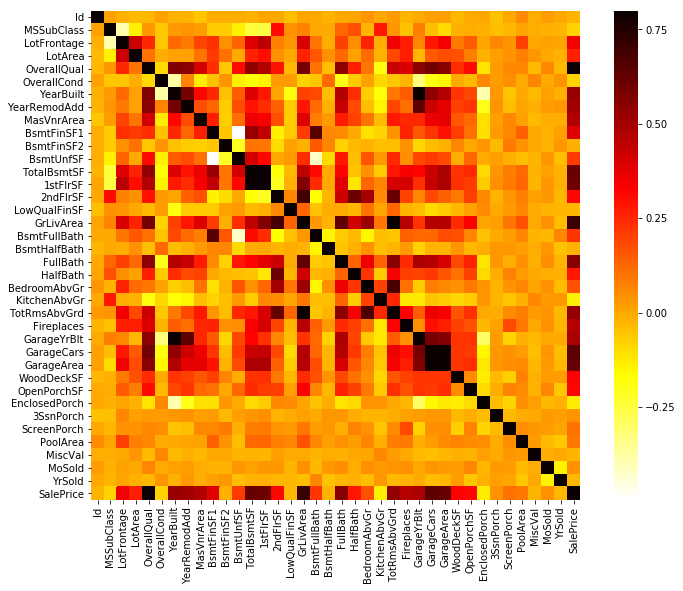

In [4]:

colormap = plt.cm.hot_r
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap=colormap);

## saleprice correlation matrix

chceme predikovat cenu - zajímavé jsou tedy hlavně data s dobrou korelací

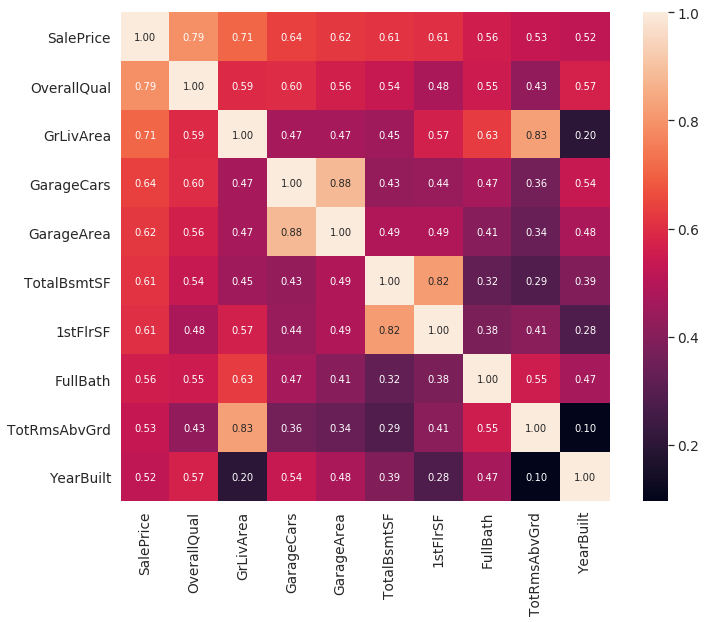

In [5]:

k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## scatterplot

Klíčové hodnoty ve vztahu 1:1

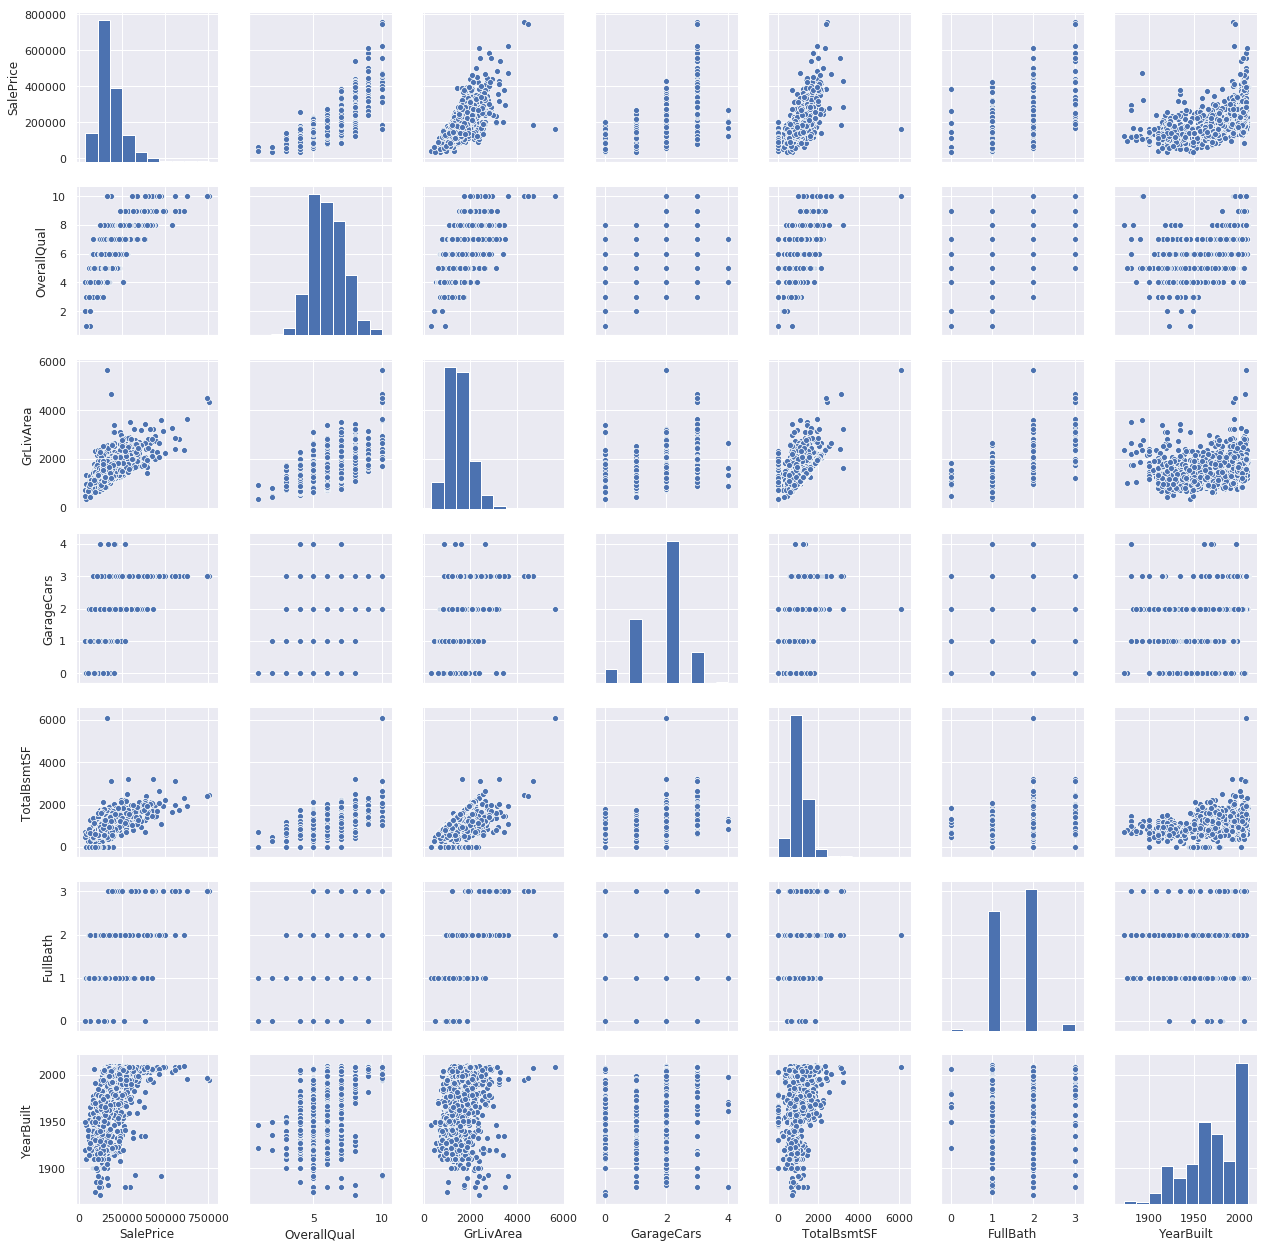

In [6]:

sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], height = 2.5)
plt.show();

## missing data

Data nejsou 100%, často někde chybí hodnota. 

* jak tuto hodnotu nahradit?
* chybí data zcela náhodně, nebo je v tom nějaký opakující se vzor?

In [7]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


### dealing with missing data

na základě předchozích pozorování můžeme smazat kompletní sloupce. Necháme Electrical, kde smažeme pouze ten jeden chybějící řádek.

In [8]:

df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #kontrola zda se to povedlo

0

## correlation matrix 2

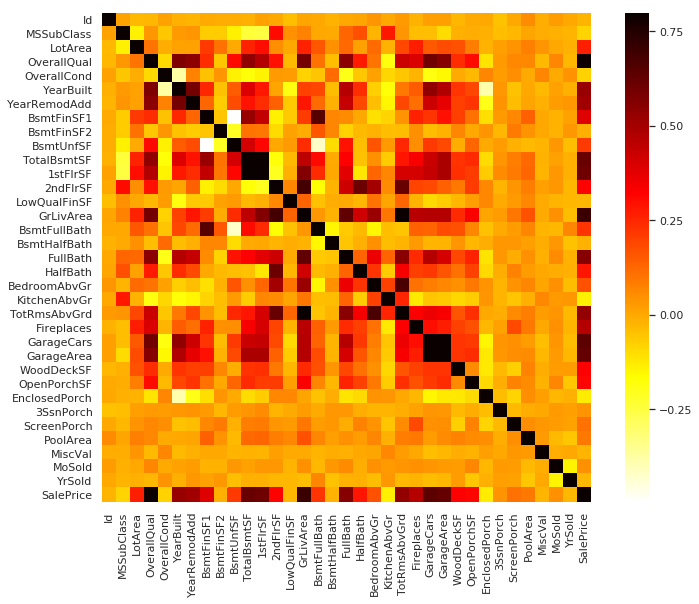

In [9]:

corrmat2 = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat2, vmax=.8, square=True, cmap=colormap);

## Extrémní hodnoty - hledání out-layers

### Standardizace dat

Transformace dat odečtením průměru zajistí, že data získají gausovské rozložení s průměrem 0 a standardní odchylkou 1. To je základní podmínka pro správnou funkčnost algoritmů jako je Support Vector Machine a dalších.

V této distribuci také rychle vyniknou extrémní hodnoty.

In [10]:
df_train['SalePrice'] = df_train['SalePrice'].astype(float)

In [11]:
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('levý okraj (low) distribuce:')
print(low_range)
print('\n pravý okraj (high) distribuce:')
print(high_range)

levý okraj (low) distribuce:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

 pravý okraj (high) distribuce:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


V datové sadě je očividně několik extrémních případů - které leží více než 3 standardní odchylky od průměru.

### Mohou tyto extrémy ovlivnit model ?

Nyní se můžeme detailněji podívat na vzájemný vztah některých sloupců - atributů.

Začneme vztahem mezi prodejní cenou (SalePrice) a plochou přízemí (GrLivArea).

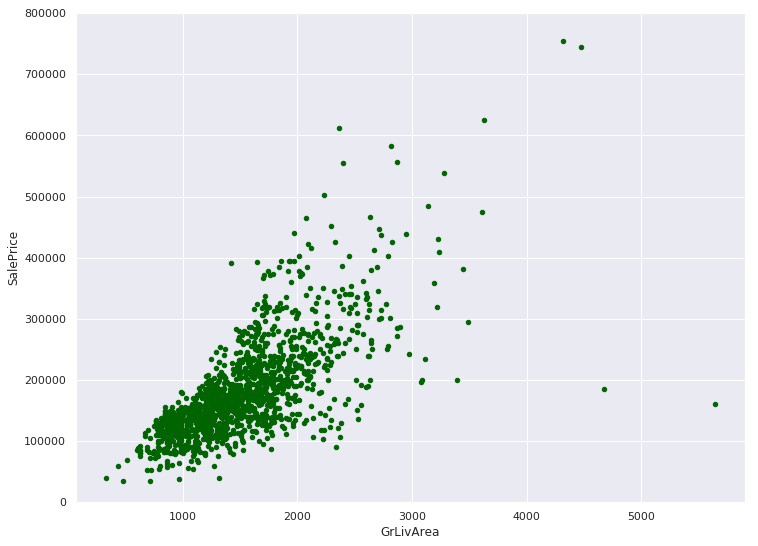

In [12]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000),figsize=(12, 9), c='DarkGreen');

Dva domy mají plochu přes 4000, ale jejich cena je mimo trend. Jsou to anomálie, které v tomto případě bude lepší smazat.

In [13]:
smazat = df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]['Id']

In [14]:
for a in smazat:
    df_train = df_train.drop(df_train[df_train['Id'] == a].index)

A ještě pohled na upravená data.

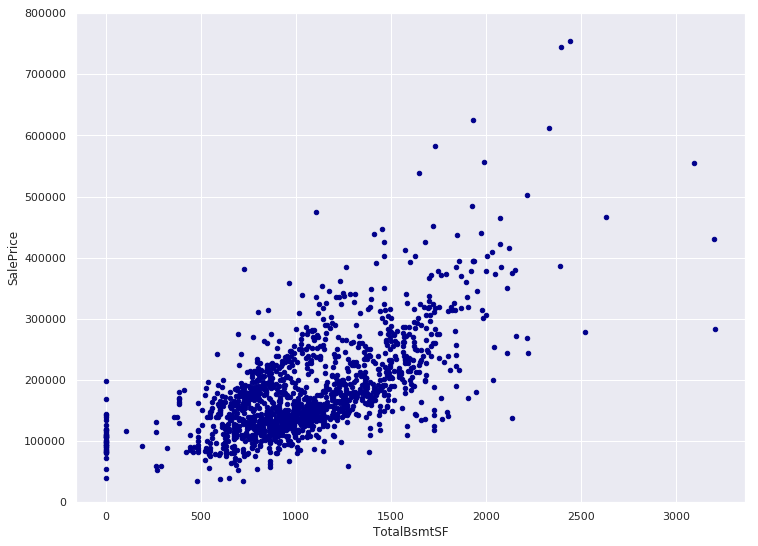

In [15]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000), figsize=(12, 9), c='DarkBlue');

## Další transformace dat

Ŕada statistických metod funguje lépe na datech s normální rozdělením (normal distribution, Gauss distribution). Častým krokem při přípravě dat je tedy zjistit jaké je jejich rozdělení a případná tranformace na normální rozdělení, pokud je možná.

/home/albert/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


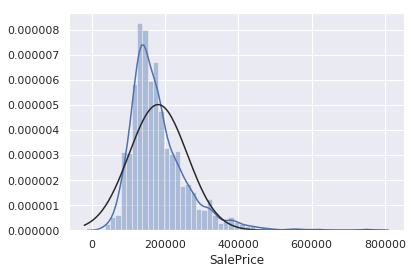

In [16]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);

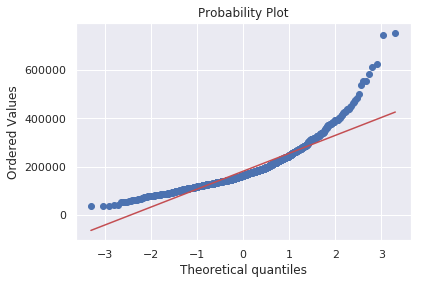

In [17]:
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

Jak je vidět z obou grafů, distribuce ceny je asymetrická (skew distribution). Jednou ze základních tranformací, kterou můžeme použít, je logaritmus.

In [18]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

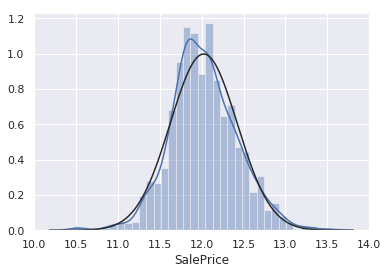

In [19]:
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);

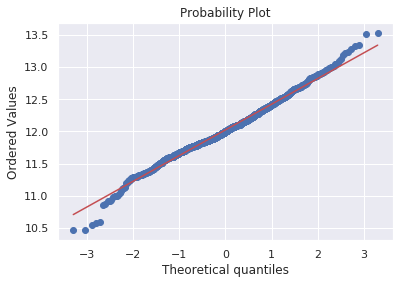

In [20]:
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

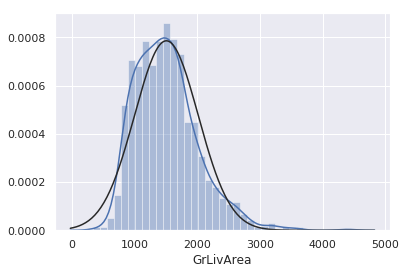

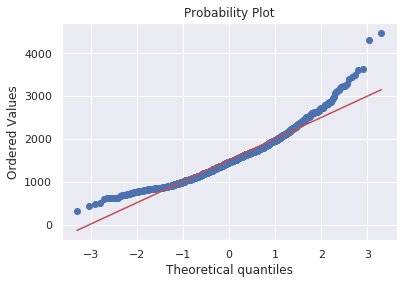

In [21]:
#histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

In [22]:
#data transformation
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

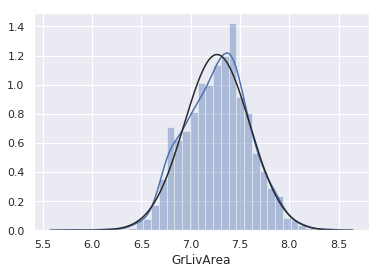

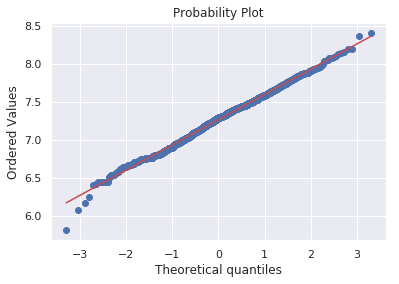

In [23]:
#transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

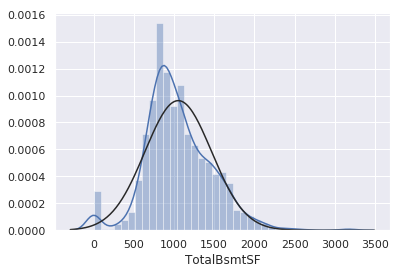

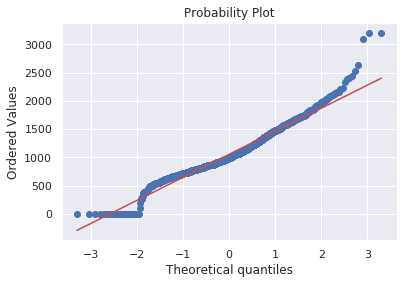

In [24]:
#histogram and normal probability plot
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)